# Identification of single-cell cluster cell types

This notebook integrates the analysis of single-cell RNA-sequencing (scRNAseq) data from the suprachiasmatic nucleus (SCN) of mice kept at 12h light:dark cycle (LD) for 2 weeks and constant darkness (DD) for 2 days before collection. Twelve samples were collected at different circadian time points.

The aim of this notebook is to show to run a general pipeline of how cell types in clusters are identified using the concatenated samples.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

#UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
#UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.

import os
import time
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
scvi.settings.seed = 0
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

Global seed set to 0


In [3]:
print(sc.__version__)
print(scvi.__version__)
print(np.__version__)
print(pd.__version__)

1.9.6
1.0.4
1.26.2
2.1.4


### Explore the files and data

In [6]:
os.listdir('data/GSE117295_RAW/')

['GSM3290582_CT14.csv.gz',
 'GSM3290583_CT18.csv.gz',
 'GSM3290584_CT22.csv.gz',
 'GSM3290585_CT26.csv.gz',
 'GSM3290586_CT30.csv.gz',
 'GSM3290587_CT34.csv.gz',
 'GSM3290588_CT38.csv.gz',
 'GSM3290589_CT42.csv.gz',
 'GSM3290590_CT46.csv.gz',
 'GSM3290591_CT50.csv.gz',
 'GSM3290592_CT54.csv.gz',
 'GSM3290593_CT58.csv.gz',
 'GSM3290594_flash.csv.gz']

__The raw data contain 6563 cells and 26469 genes__

In [9]:
adata = sc.read_csv('data/GSE117295_RAW/GSM3290582_CT14.csv.gz').T

In [10]:
adata

AnnData object with n_obs × n_vars = 6563 × 26469

In [11]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Calculate QC metrics

In [13]:
sc.pp.calculate_qc_metrics(adata, layer=None, use_raw=False, inplace=True)

In [14]:
adata.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0610007P14Rik,437,0.075118,0.072431,93.341460,493.0,6.202536
0610009B22Rik,466,0.084108,0.080757,92.899589,552.0,6.315358
0610009E02Rik,50,0.008228,0.008194,99.238153,54.0,4.007333
0610009L18Rik,183,0.031540,0.031053,97.211641,207.0,5.337538
0610009O20Rik,223,0.036264,0.035622,96.602164,238.0,5.476463
...,...,...,...,...,...,...
n-R5s33,1,0.000152,0.000152,99.984763,1.0,0.693147
n-R5s47,0,0.000000,0.000000,100.000000,0.0,0.000000
n-R5s7,0,0.000000,0.000000,100.000000,0.0,0.000000
n-R5s88,1,0.000152,0.000152,99.984763,1.0,0.693147


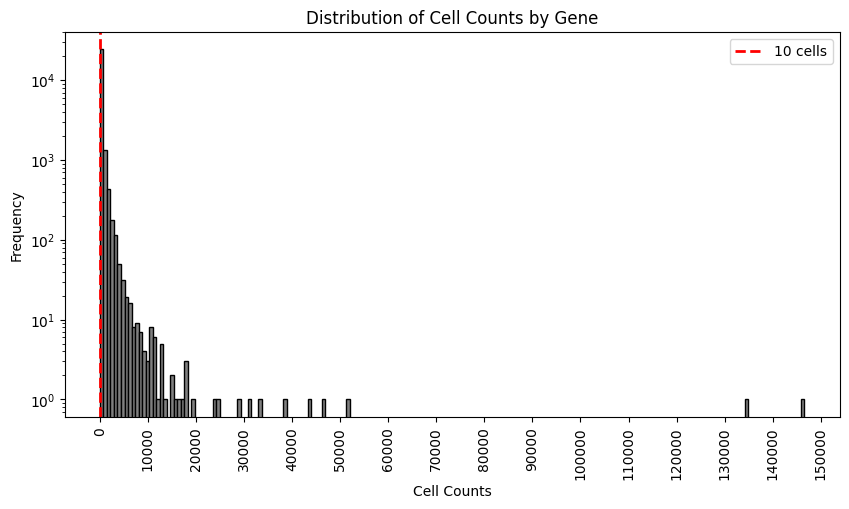

In [15]:
plt.figure(figsize=(10, 5))

plt.hist(adata.var['total_counts'], bins=200, color='gray', edgecolor='black')
plt.yscale('log')

plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 cells')

plt.locator_params(axis='x', nbins=30)

plt.xticks(rotation=90, ha='center')

plt.xlabel('Cell Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Counts by Gene')

plt.legend()
plt.show()

In [16]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
TAAAGTCGTGAT,200,5.303305,303.0,5.717028,50.495050,66.996700,100.000000,100.000000
CATAACTGATGT,200,5.303305,241.0,5.488938,37.759336,58.506224,100.000000,100.000000
AAAAGTGTGTCC,200,5.303305,254.0,5.541264,40.944882,60.629921,100.000000,100.000000
GAGTCGCCGTTC,201,5.308268,276.0,5.624018,45.289855,63.405797,99.637681,100.000000
CCAGAAAGGATA,201,5.308268,251.0,5.529429,39.840637,59.760956,99.601594,100.000000
...,...,...,...,...,...,...,...,...
GCTATGCTATCA,4993,8.515992,14397.0,9.574844,16.559005,21.962909,29.450580,44.002223
GCGCTCTAACAA,5650,8.639588,15406.0,9.642577,16.344281,21.420226,28.229261,41.542256
TACTCGTCCATT,5722,8.652248,17830.0,9.788693,11.362872,16.556366,24.054964,39.040942
AGAAGTGCGAGC,5849,8.674197,17672.0,9.779794,16.279991,21.327524,28.463105,41.772295


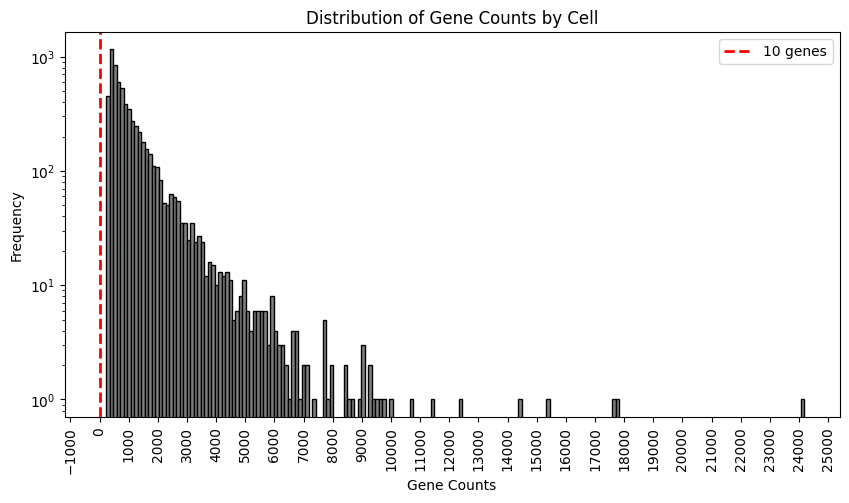

In [17]:
plt.figure(figsize=(10, 5))

plt.hist(adata.obs['total_counts'], bins=200, color='gray', edgecolor='black')
plt.yscale('log')

plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 genes')

plt.locator_params(axis='x', nbins=30)

plt.xticks(rotation=90, ha='center')

plt.xlabel('Gene Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Counts by Cell')

plt.legend()
plt.show()

### Run the data preprocessing Python script

`bash run_preprocessing.sh`

- Doublet Removal: More than one cell can end up in the same droplet when the libraries are made, sharing the same barcode. Duplicates should be removed to avoid incorrect inferences about the data.
  - Training a model to predict doublet cells.
    - Setup a scVI model to make predictions.
    - Train a Solo model to predict doublets, passing the previously created model. Solo is a semi-supervised deep learning method used to identify doublets [Ref](https://doi.org/10.1016/j.cels.2020.05.010). It simulates doublets and then trains a classifier. Alternative methods include Scrublet and DoubletFinder.
    - Prediction of doublets. Higher scores indicate doublets.
- Outlier cell removal.
  - Filter the data to retain only those cells where the number of expressed genes is less than the calculated upper limit.
- Mitochondrial and Ribosomal gene removal. 

### Import the processed data

In [22]:
adata = sc.read_h5ad('data/wen2020.h5ad')
adata.obs_names_make_unique
#UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 50725 × 20376
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'>

__Summary of counts per sample__

In [24]:
adata.obs.groupby('Sample', observed=False).count()

# FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 
# Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
CT14.csv.gz,6052,6052,6052,6052,6052,6052,6052,6052
CT18.csv.gz,5859,5859,5859,5859,5859,5859,5859,5859
CT26.csv.gz,5358,5358,5358,5358,5358,5358,5358,5358
CT30.csv.gz,4933,4933,4933,4933,4933,4933,4933,4933
CT34.csv.gz,3665,3665,3665,3665,3665,3665,3665,3665
CT38.csv.gz,3499,3499,3499,3499,3499,3499,3499,3499
CT42.csv.gz,5259,5259,5259,5259,5259,5259,5259,5259
CT46.csv.gz,4313,4313,4313,4313,4313,4313,4313,4313
CT50.csv.gz,3277,3277,3277,3277,3277,3277,3277,3277


In [25]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAAAGTCGTGAT,CT14.csv.gz,False,200,200,303.0,8.0,2.640264,0.0,0.0
CATAACTGATGT,CT14.csv.gz,False,200,200,241.0,3.0,1.244813,0.0,0.0
AAAAGTGTGTCC,CT14.csv.gz,False,200,200,254.0,8.0,3.149606,0.0,0.0
GAGTCGCCGTTC,CT14.csv.gz,False,201,201,276.0,31.0,11.231884,0.0,0.0
CCAGAAAGGATA,CT14.csv.gz,False,201,201,251.0,15.0,5.976096,0.0,0.0


### The data are filtered for cells containing counts of mitochondrial genes at at most the 20th percentile

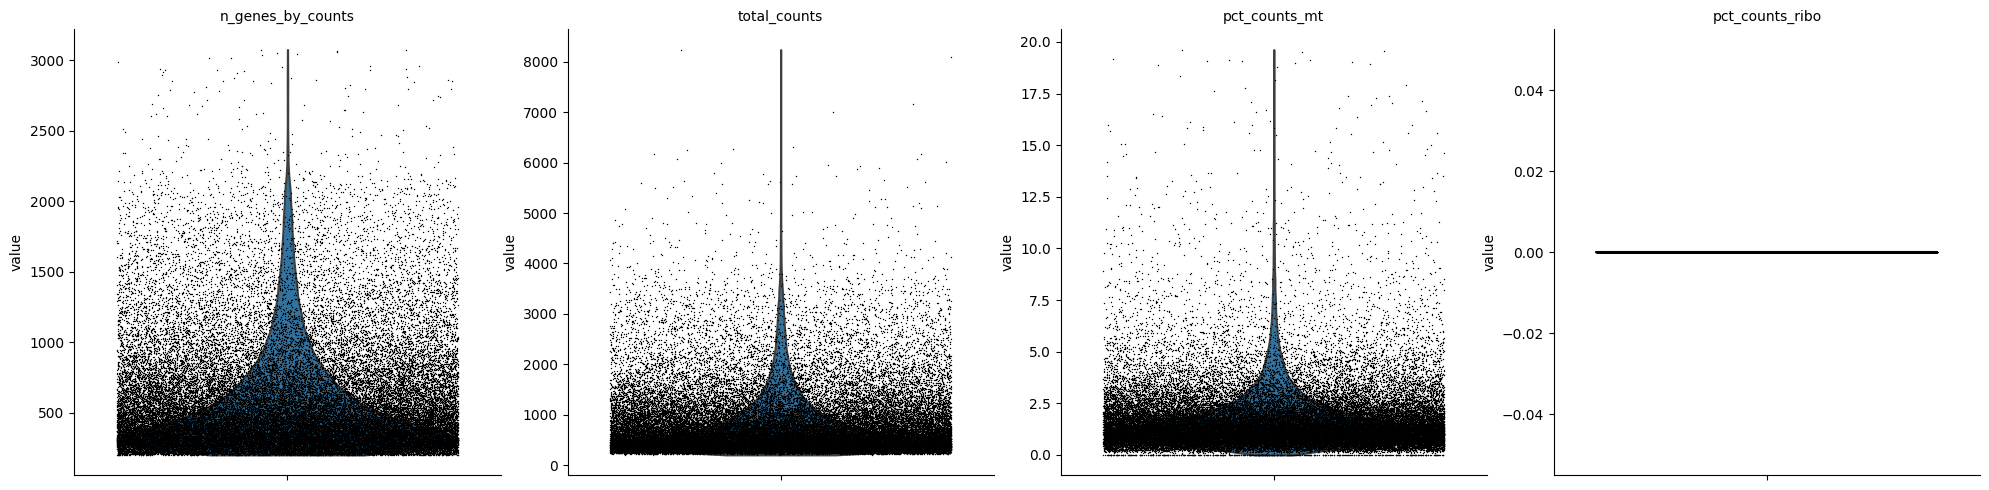

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

#FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
#FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

### Run integration of the data

`bash run_model.sh`

Train a scVI model to run downstream data analyses.

### Import the integrated data

In [32]:
adata = sc.read_h5ad('data/wen2020_integrated.h5ad')
adata.obs_names_make_unique
#UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 50725 × 20376
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'>

### Import the model

In [42]:
vae = scvi.model.SCVI.load('data/wen2020_model', adata)
#<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.
#For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.
#For creation, use `anndata.experimental.sparse_dataset(X)` instead.

INFO     File data/wen2020_model/model.pt already downloaded                                                       


In [49]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [50]:
#sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, layer='counts',
#                            flavor = "seurat_v3", batch_key="Sample")

### Get the latent representation to capture features or patterns in the data

In [54]:
vae.get_latent_representation().shape
#<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.
#For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.
#For creation, use `anndata.experimental.sparse_dataset(X)` instead.

(50725, 10)

In [59]:
adata.obsm['X_scVI'] = vae.get_latent_representation()

### Normalize the expression values and save as a layer instead of overwriting the raw values

In [61]:
adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size = 1e4)

In [62]:
adata.layers['scvi_normalized']

array([[5.7164121e-01, 4.0849128e-01, 5.9651360e-02, ..., 2.7269563e-03,
        6.1269393e-03, 2.1821370e-03],
       [4.4096920e-01, 6.3674873e-01, 4.1969347e-01, ..., 1.2392210e-02,
        1.3759190e-02, 1.1337809e-03],
       [1.0602217e+00, 6.8229079e-01, 8.3027489e-02, ..., 3.2938407e-03,
        1.0145796e-03, 1.6259574e-03],
       ...,
       [1.1416157e+00, 9.4203424e-01, 2.6187103e-02, ..., 4.4955611e-03,
        5.0225683e-02, 1.8426543e-02],
       [1.2843633e+00, 7.9767245e-01, 5.5526197e-02, ..., 9.6655302e-03,
        6.0897592e-02, 2.7581995e-02],
       [1.1128709e+00, 1.0119805e+00, 2.8238235e-02, ..., 5.1577119e-03,
        5.2280165e-02, 7.0883920e-03]], dtype=float32)

### Clustering
__Use the latent representation from 'X_scVI' to calculate the neighbors__

In [71]:
sc.pp.neighbors(adata, use_rep='X_scVI')

__Run UMAP and the Leiden algorithm for dimensionality reduction and clustering__

(SLOW)

In [75]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

__Plot the UMAP to see the result of the integration__

- Clusters labeled
- Samples labeled

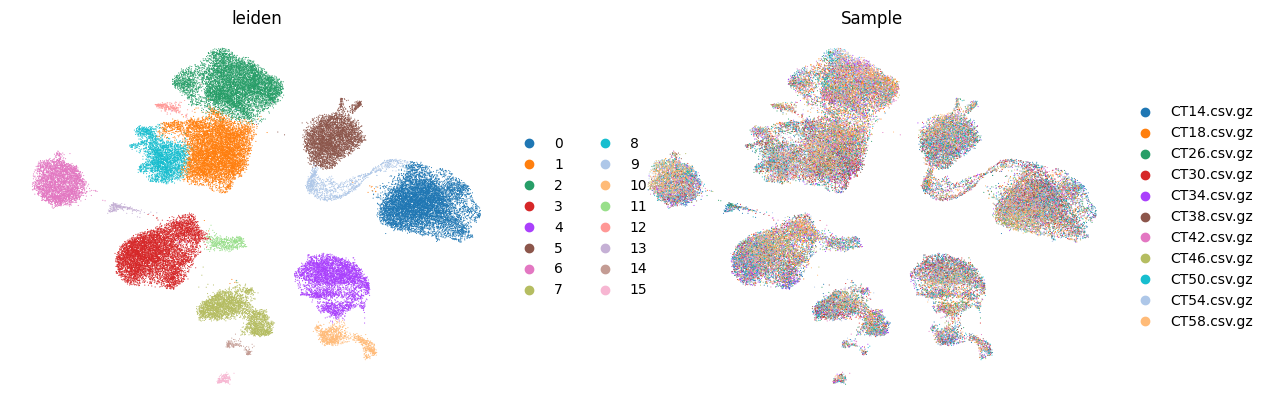

In [76]:
sc.pl.umap(adata, color=['leiden', 'Sample'], frameon=False)
#FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
#UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
#FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
#UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

### Identify the cell types

__Get the gene markers for each cluster__

In [81]:
sc.tl.rank_genes_groups(adata, 'leiden')    # SLOW
#method=''
# WARNING: Default of the method has been changed to 't-test' from 't-test_overestim_var'

In [83]:
sc.get.rank_genes_groups_df(adata, None)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Plp1,768.635986,9.658649,0.0,0.0
1,0,Mal,377.352783,8.593007,0.0,0.0
2,0,Cldn11,302.191040,8.697701,0.0,0.0
3,0,Fth1,296.334656,4.457051,0.0,0.0
4,0,Mbp,286.555298,5.333561,0.0,0.0
...,...,...,...,...,...,...
326011,15,Kcnj10,-89.963448,-28.927563,0.0,0.0
326012,15,Tspan2,-92.871033,-29.172028,0.0,0.0
326013,15,Ly6h,-97.589737,-29.051722,0.0,0.0
326014,15,Ptprz1,-101.683212,-29.556080,0.0,0.0


__Filter the markers by the adjusted P-value and log fold change__

In [86]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Plp1,768.635986,9.658649,0.000000,0.000000
1,0,Mal,377.352783,8.593007,0.000000,0.000000
2,0,Cldn11,302.191040,8.697701,0.000000,0.000000
3,0,Fth1,296.334656,4.457051,0.000000,0.000000
4,0,Mbp,286.555298,5.333561,0.000000,0.000000
...,...,...,...,...,...,...
306184,15,Mier1,2.184605,1.060622,0.030350,0.048952
306185,15,Tgfbrap1,2.181949,1.713457,0.030551,0.049268
306186,15,1700027J19Rik,2.179977,4.991838,0.030702,0.049504
306187,15,Setbp1,2.179766,2.142458,0.030716,0.049523


__Calculate the marker genes__

In [95]:
markers_scvi = vae.differential_expression(groupby='leiden')    # SLOW
markers_scvi

DE...: 100%|██████████████████████████████████████| 16/16 [15:01<00:00, 56.34s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Pls1,1.0000,0.0000,18.420681,0.000191,0.000002,0.0,0.25,7.102828,6.985395,1.751136,...,0.204897,0.001227,0.174169,0.001227,2.369262,0.011583,True,0 vs Rest,0,Rest
Pex5l,1.0000,0.0000,18.420681,0.000915,0.000026,0.0,0.25,5.569740,5.487924,1.431004,...,0.864362,0.021866,0.500420,0.019224,10.100221,0.242074,True,0 vs Rest,0,Rest
Car2,1.0000,0.0000,18.420681,0.004789,0.000120,0.0,0.25,6.307089,6.387561,1.933658,...,4.862922,0.061683,0.937943,0.049960,57.808693,1.054584,True,0 vs Rest,0,Rest
Gm21984,0.9998,0.0002,8.516943,0.000855,0.000009,0.0,0.25,7.233850,7.013911,1.918582,...,0.788621,0.001462,0.467051,0.001321,9.288730,0.023013,True,0 vs Rest,0,Rest
RP24-163K4.1,0.9998,0.0002,8.516943,0.000286,0.000003,0.0,0.25,7.196712,7.265259,1.966252,...,0.239347,0.001156,0.189773,0.001109,2.970978,0.016050,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rbm39,0.5966,0.4034,0.391318,0.000990,0.000918,0.0,0.25,0.137656,0.101735,0.493777,...,0.552147,0.711265,0.417178,0.425339,10.141970,8.847909,False,15 vs Rest,15,Rest
Pa2g4,0.5916,0.4084,0.370584,0.000124,0.000130,0.0,0.25,-0.023314,-0.031093,0.491947,...,0.067485,0.112575,0.061350,0.098908,1.616678,1.368106,False,15 vs Rest,15,Rest
Ddx47,0.5824,0.4176,0.332633,0.000067,0.000062,0.0,0.25,0.141035,0.124946,0.453286,...,0.036810,0.054705,0.036810,0.050453,0.706145,0.658414,False,15 vs Rest,15,Rest
Snw1,0.5506,0.4494,0.203095,0.000272,0.000266,0.0,0.25,0.074259,0.044090,0.437904,...,0.190184,0.218642,0.153374,0.171473,3.986078,2.643573,False,15 vs Rest,15,Rest


__Filter the DataFrame based on false discovery rate and lfc mean value of at least 0.5__

In [112]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > 0.5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Pls1,1.0000,0.0000,18.420681,0.000191,0.000002,0.0,0.25,7.102828,6.985395,1.751136,...,0.204897,0.001227,0.174169,0.001227,2.369262,0.011583,True,0 vs Rest,0,Rest
Pex5l,1.0000,0.0000,18.420681,0.000915,0.000026,0.0,0.25,5.569740,5.487924,1.431004,...,0.864362,0.021866,0.500420,0.019224,10.100221,0.242074,True,0 vs Rest,0,Rest
Car2,1.0000,0.0000,18.420681,0.004789,0.000120,0.0,0.25,6.307089,6.387561,1.933658,...,4.862922,0.061683,0.937943,0.049960,57.808693,1.054584,True,0 vs Rest,0,Rest
Gm21984,0.9998,0.0002,8.516943,0.000855,0.000009,0.0,0.25,7.233850,7.013911,1.918582,...,0.788621,0.001462,0.467051,0.001321,9.288730,0.023013,True,0 vs Rest,0,Rest
RP24-163K4.1,0.9998,0.0002,8.516943,0.000286,0.000003,0.0,0.25,7.196712,7.265259,1.966252,...,0.239347,0.001156,0.189773,0.001109,2.970978,0.016050,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Irs1,0.9178,0.0822,2.412824,0.000015,0.000013,0.0,0.25,0.838198,0.840372,1.873855,...,0.012270,0.008504,0.012270,0.008129,0.143729,0.108949,True,15 vs Rest,15,Rest
4930579G24Rik,0.9178,0.0822,2.412824,0.000013,0.000007,0.0,0.25,1.422409,1.419640,1.584791,...,0.000000,0.003402,0.000000,0.003303,0.000000,0.045871,True,15 vs Rest,15,Rest
Gm10080,0.9178,0.0822,2.412824,0.000037,0.000024,0.0,0.25,1.106525,1.187075,1.268262,...,0.012270,0.016791,0.012270,0.016435,0.232264,0.223143,True,15 vs Rest,15,Rest
4930426I24Rik,0.9178,0.0822,2.412824,0.000003,0.000004,0.0,0.25,0.752888,0.641936,2.147609,...,0.000000,0.000672,0.000000,0.000613,0.000000,0.009459,True,15 vs Rest,15,Rest


__Plot the cluster labels on top of the UMAP__

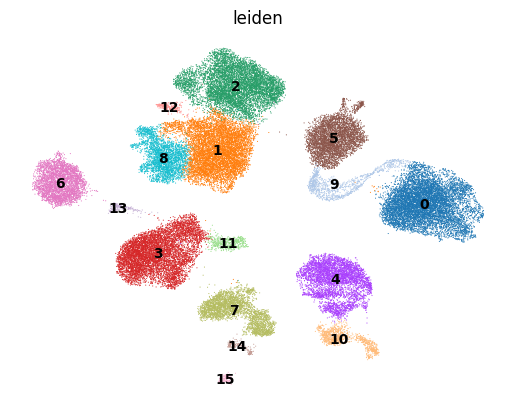

In [194]:
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data')
#color=['leiden'], 

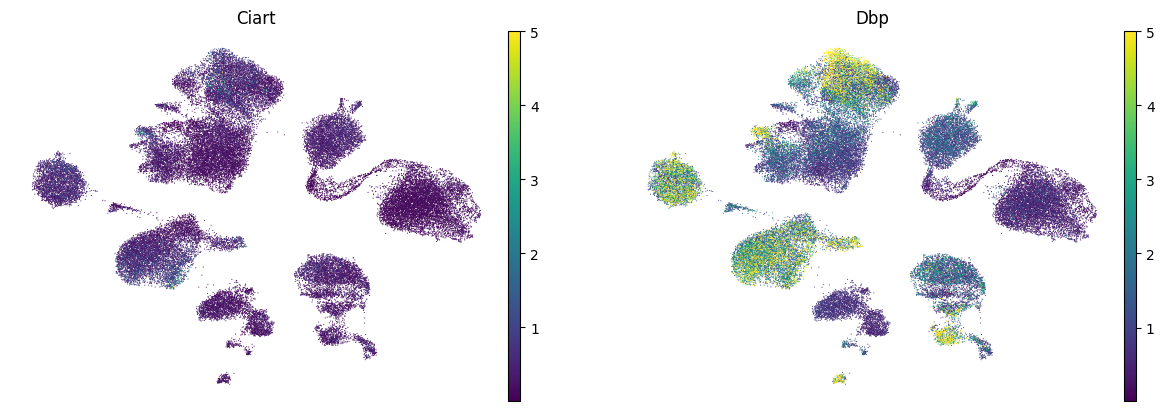

In [116]:
sc.pl.umap(adata, color=['Ciart', 'Dbp'], frameon=False, layer='scvi_normalized', vmax=5)

In [117]:
markers[(markers.names == 'Ciart') | (markers.names == 'Dbp')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
41577,2,Dbp,16.494282,1.069769,3.464685e-60,3.100414e-59
46340,2,Ciart,3.884015,0.648057,1.035059e-04,2.046019e-04
61841,3,Dbp,8.790284,0.632786,1.794552e-18,5.577453e-18
122878,6,Dbp,17.084309,1.528604,5.098836e-63,5.746343e-62
127184,6,Ciart,2.344347,0.550997,1.911208e-02,3.124421e-02
204204,10,Dbp,5.712548,1.025437,1.448639e-08,4.146293e-08
224336,11,Dbp,5.262115,1.347525,2.118189e-07,5.081260e-07
306023,15,Dbp,2.778742,1.184238,6.100046e-03,1.043878e-02


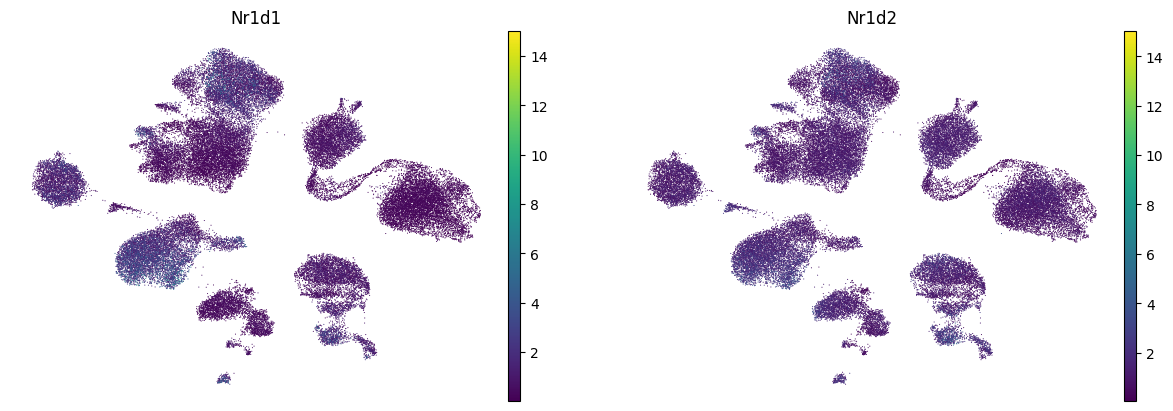

In [118]:
sc.pl.umap(adata, color=['Nr1d1', 'Nr1d2'], frameon=False, layer='scvi_normalized', vmax=15)

In [119]:
markers[(markers.names == 'Nr1d1') | (markers.names == 'Nr1d2')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
41843,2,Nr1d1,14.370213,1.269737,2.881719e-46,2.109878e-45
61736,3,Nr1d1,10.201244,1.014319,2.771327e-24,9.996206e-24
124212,6,Nr1d1,7.617235,0.919633,3.265651e-14,1.278158e-13
204772,10,Nr1d2,2.628282,0.561548,8.706470e-03,1.450675e-02
204804,10,Nr1d1,2.535737,0.624149,1.136478e-02,1.870543e-02
224728,11,Nr1d1,2.668955,0.924670,7.856206e-03,1.288147e-02
265303,13,Nr1d2,3.274086,1.331519,1.232870e-03,2.919684e-03
305964,15,Nr1d1,3.091259,1.751703,2.346232e-03,4.138043e-03


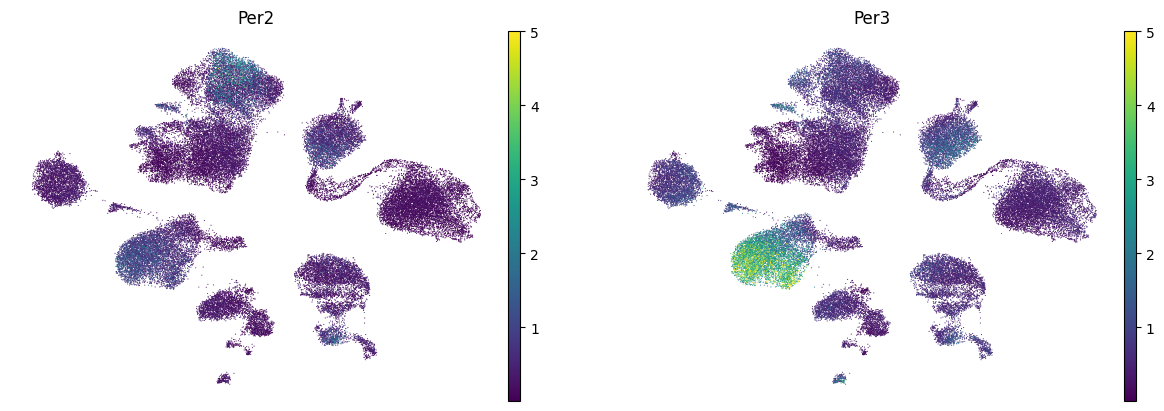

In [120]:
sc.pl.umap(adata, color=['Per2', 'Per3'], frameon=False, layer='scvi_normalized', vmax=5)

In [121]:
markers[(markers.names == 'Per2') | (markers.names == 'Per3')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
41764,2,Per2,14.874741,1.905911,2.276794e-49,1.753949e-48
61346,3,Per3,20.748682,2.148089,5.546593e-93,5.263968e-92
62364,3,Per2,4.783666,0.686930,1.751955e-06,3.299245e-06
125248,6,Per3,4.885968,0.585912,1.071427e-06,2.740227e-06
265757,13,Per3,2.379806,1.110653,1.818341e-02,3.815909e-02


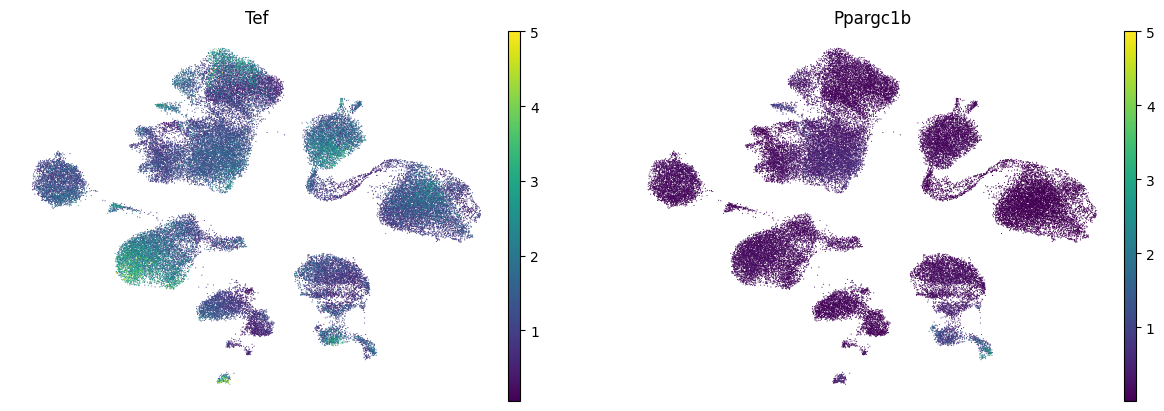

In [122]:
sc.pl.umap(adata, color=['Tef', 'Ppargc1b'], frameon=False, layer='scvi_normalized', vmax=5)

In [123]:
markers[(markers.names == 'Tef') | (markers.names == '')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
265567,13,Tef,2.65187,0.925002,0.008592,0.018793


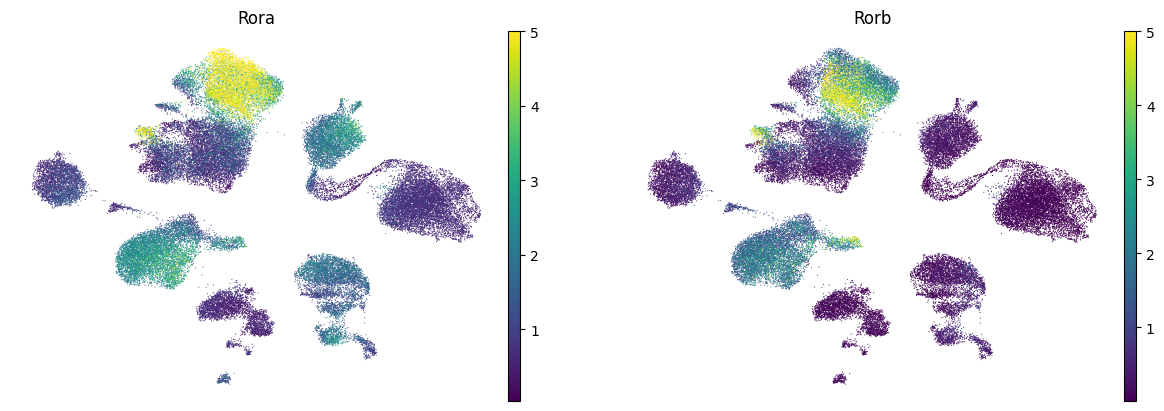

In [172]:
sc.pl.umap(adata, color=['Rora', 'Rorb'], frameon=False, layer='scvi_normalized', vmax=5)

In [125]:
markers[(markers.names == 'Rora') | (markers.names == 'Rorb')]

,group,names,scores,logfoldchanges,pvals,pvals_adj
40815,2,Rora,49.108742,3.152542,0.000000e+00,0.000000e+00
40881,2,Rorb,36.838348,3.471868,9.909852e-273,4.323836e-271
224589,11,Rorb,3.258005,1.112693,1.198396e-03,2.114523e-03


In [186]:
# Adjust the resolution
#sc.tl.leiden(adata, resolution = 0.5)
#sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data')

### Identify the cell types in each cluster

Use resources like [PanglaoDB](https://panglaodb.se/markers.html) to find information about cell clusters and identify the cell types in the data.

In [136]:
markers_scvi[markers_scvi['group1']=='10'][:20]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C1s1,0.9998,0.0002,8.516943,0.000163,0.000001,0.0,0.25,8.395204,8.454348,2.317049,...,0.070874,0.000483,0.062136,0.000443,1.391706,0.006660,True,10 vs Rest,10,Rest
Twist1,0.9996,0.0004,7.823621,0.000043,0.000001,0.0,0.25,6.837390,6.953450,1.983212,...,0.015534,0.000463,0.015534,0.000463,0.360792,0.007681,True,10 vs Rest,10,Rest
Mrvi1,0.9996,0.0004,7.823621,0.000177,0.000002,0.0,0.25,6.994433,6.996414,2.122715,...,0.109709,0.001167,0.092233,0.001107,2.085339,0.015896,True,10 vs Rest,10,Rest
Gprc5c,0.9996,0.0004,7.823621,0.000313,0.000007,0.0,0.25,7.004813,7.043593,2.301566,...,0.147573,0.003803,0.135922,0.003421,3.320680,0.045413,True,10 vs Rest,10,Rest
Slc38a11,0.9996,0.0004,7.823621,0.000431,0.000004,0.0,0.25,7.966825,7.985957,2.112027,...,0.225243,0.003119,0.186408,0.002938,4.789711,0.037788,True,10 vs Rest,10,Rest
Notch3,0.9996,0.0004,7.823621,0.000613,0.000011,0.0,0.25,8.099767,8.558910,2.545751,...,0.339806,0.007727,0.266990,0.007103,7.387033,0.133975,True,10 vs Rest,10,Rest
Gm13861,0.9996,0.0004,7.823621,0.000529,0.000004,0.0,0.25,9.658500,9.846622,2.408759,...,0.266019,0.003300,0.210680,0.002878,5.840939,0.044163,True,10 vs Rest,10,Rest
Phldb2,0.9994,0.0006,7.417964,0.000745,0.000027,0.0,0.25,6.142437,6.191913,2.148525,...,0.389320,0.014187,0.276699,0.012134,8.216643,0.221606,True,10 vs Rest,10,Rest
C1qtnf2,0.9994,0.0006,7.417964,0.000141,0.000004,0.0,0.25,6.605766,6.617741,2.322804,...,0.057282,0.002254,0.056311,0.002133,1.312782,0.029791,True,10 vs Rest,10,Rest
Inpp4b,0.9994,0.0006,7.417964,0.000354,0.000025,0.0,0.25,4.345173,4.228067,1.484458,...,0.179612,0.013241,0.150485,0.012255,4.013594,0.181966,True,10 vs Rest,10,Rest


In [140]:
{str(key): f'_{key}' for key in range(16)}

{'0': '_0',
 '1': '_1',
 '2': '_2',
 '3': '_3',
 '4': '_4',
 '5': '_5',
 '6': '_6',
 '7': '_7',
 '8': '_8',
 '9': '_9',
 '10': '_10',
 '11': '_11',
 '12': '_12',
 '13': '_13',
 '14': '_14',
 '15': '_15'}

In [142]:
cell_type = {
 '0': 'Oligodendrocytes',
 '1': 'Neurons',
 '2': 'Neurons',
 '3': 'Astrocytes',
 '4': 'Endothelial cells',
 '5': 'Oligodendrocytes',
 '6': 'Ependymal cells',
 '7': 'Microglia',
 '8': 'Neurons',
 '9': 'Oligodendrocytes',
 '10': 'Unknown_1',
 '11': 'Astrocytes?',
 '12': 'Neurons',
 '13': 'Tanycytes?',
 '14': 'Unknown_2',
 '15': 'Fibroblasts?'
}

In [164]:
genes = ['Aanat',
'Ada',
'Adcy1',
'Adipoq',
'Adora1',
'Adora2a',
'Adra1a',
'Adra1b',
'Agrp',
'Ahcy',
'Ahr',
'Ak5',
'Ank3',
'Arntl',
'Arntl2',
'Arrdc1',
'Ascl1',
'Asmt',
'Atf4',
'Atf5',
'Atoh7',
'Bank1',
'Bhlhe40',
'Bhlhe41',
'Btbd9',
'Btrc',
'C1orf54',
'C3orf18',
'Calcoco2',
'Cartpt',
'Cavin3',
'Ccar2',
'Cdh23',
'Cdk4',
'Chrnb2',
'Ciart',
'Cipc',
'Cldn4',
'Clock',
'Cpt1a',
'Creb1',
'Crem',
'Crh',
'Crtc1',
'Cry1',
'Cry2',
'Csnk1d',
'Csnk1e',
'Ctsf',
'Ctss',
'Dbp',
'Ddc',
'Dnajc16',
'Drd1',
'Drd2',
'Drd3',
'Drd4',
'Dyrk1a',
'Ece1',
'Egr1',
'Egr3',
'Ep300',
'Ezh2',
'F7',
'Fabp5',
'Fam3d',
'Fbxl13',
'Fbxl3',
'Fbxw11',
'Fev',
'Foxa2',
'Gabbr1',
'Gabra1',
'Gata2',
'Gata3',
'Gfpt1',
'Ghrh',
'Ghrl',
'Gna11',
'Gnai2',
'Gnaq',
'Gprc5b',
'Grb10',
'Gsk3b',
'Hck',
'Hcrtr2',
'Hdac1',
'Hdac2',
'Hdac3',
'Hebp1',
'Hnf1b',
'Hnrnpd',
'Hnrnpu',
'Hs3st2',
'Htr1a',
'Htr1b',
'Htr1d',
'Htr2a',
'Htr2c',
'Htr7',
'Id2',
'Id3',
'Id4',
'Insm1',
'Ism1',
'Itpkb',
'Jun',
'Jund',
'Kank1',
'Kcnd2',
'Kcnh2',
'Kcnh7',
'Kcnk2',
'Kcnk3',
'Kcnn3',
'Kdm5a',
'Klf10',
'Klf9',
'Klhl29',
'Kmt2a',
'Lep',
'Lgr4',
'Lmx1b',
'Lrpprc',
'Macrod2',
'Magel2',
'Maoa',
'Mapk10',
'Mapk8',
'Mapk9',
'Mc3r',
'Mdfic',
'Mettl3',
'Mta1',
'Mtnr1a',
'Mtnr1b',
'Mttp',
'Mxd3',
'Mybbp1a',
'Mycbp2',
'Naglu',
'Nampt',
'Ncoa2',
'Ncor1',
'Nfil3',
'Ngfr',
'Nkx2-1',
'Nkx2-2',
'Nlgn1',
'Nms',
'Noct',
'Nos2',
'Npas2',
'Nps',
'Npy2r',
'Nr1d1',
'Nr1d2',
'Nr1h3',
'Nr2f6',
'Nr3c1',
'Nrip1',
'Nt5c2',
'Ntn1',
'Ntrk1',
'Ntrk3',
'Opn3',
'Opn4',
'Opn5',
'Oprl1',
'Pax4',
'Pcyox1',
'Per1',
'Per2',
'Per3',
'Pfkfb4',
'Phlpp1',
'Pml',
'Ppara',
'Pparg',
'Ppargc1a',
'Ppp1ca',
'Ppp1cb',
'Ppp1cc',
'Prepl',
'Prf1',
'Prkaa1',
'Prkaa2',
'Prkcg',
'Prkdc',
'Prkg2',
'Prmt5',
'Prok1',
'Prok2',
'Prokr2',
'Prox1',
'Pspc1',
'Pten',
'Ptgds',
'Ptprj',
'Ptprm',
'Rabgap1l',
'Rai1',
'Rbm19',
'Rbm4',
'Rbm4b',
'Relb',
'Rere',
'Rho',
'Rnf123',
'Rnf157',
'Rock2',
'Rora',
'Rorb',
'Rorc',
'Serpine1',
'Setx',
'Sfpq',
'Sh3bp2',
'Sik1',
'Sin3a',
'Sirt1',
'Six3',
'Slc6a2',
'Slc6a4',
'Sox14',
'Srebf1',
'Star',
'Suv39h2',
'Tef',
'Th',
'Thrap3',
'Timeless',
'Tnfrsf11a',
'Top1',
'Top2a',
'Tp53',
'Tph1',
'Tph2',
'Tshz1',
'Tyms',
'Ube2b',
'Ube3a',
'Usp2',
'Usp7',
'Zbtb16',
'Zcchc7',
'Zfhx3']
adata.var[adata.var.index.isin(genes)].index.values

array(['Ada', 'Adcy1', 'Adora1', 'Adora2a', 'Adra1a', 'Adra1b', 'Agrp',
       'Ahcy', 'Ahr', 'Ak5', 'Ank3', 'Arntl', 'Arntl2', 'Arrdc1', 'Ascl1',
       'Atf4', 'Atf5', 'Bank1', 'Bhlhe40', 'Bhlhe41', 'Btbd9', 'Btrc',
       'Calcoco2', 'Cartpt', 'Ccar2', 'Cdh23', 'Cdk4', 'Chrnb2', 'Ciart',
       'Cipc', 'Clock', 'Cpt1a', 'Creb1', 'Crem', 'Crh', 'Crtc1', 'Cry1',
       'Cry2', 'Csnk1d', 'Csnk1e', 'Ctsf', 'Ctss', 'Dbp', 'Ddc',
       'Dnajc16', 'Drd1', 'Dyrk1a', 'Ece1', 'Egr1', 'Ep300', 'Ezh2',
       'Fabp5', 'Fbxl13', 'Fbxl3', 'Fbxw11', 'Gabbr1', 'Gabra1', 'Gata2',
       'Gfpt1', 'Ghrh', 'Gna11', 'Gnai2', 'Gnaq', 'Gprc5b', 'Grb10',
       'Gsk3b', 'Hck', 'Hcrtr2', 'Hdac1', 'Hdac2', 'Hdac3', 'Hebp1',
       'Hnf1b', 'Hnrnpd', 'Hnrnpu', 'Hs3st2', 'Htr1a', 'Htr1b', 'Htr1d',
       'Htr2c', 'Htr7', 'Id2', 'Id3', 'Id4', 'Insm1', 'Ism1', 'Itpkb',
       'Jun', 'Jund', 'Kank1', 'Kcnd2', 'Kcnh2', 'Kcnh7', 'Kcnk2',
       'Kcnk3', 'Kcnn3', 'Kdm5a', 'Klf10', 'Klf9', 'Klhl29', 'Kmt2a',
       

__Add new cluster labels to adata.obs__

In [144]:
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)

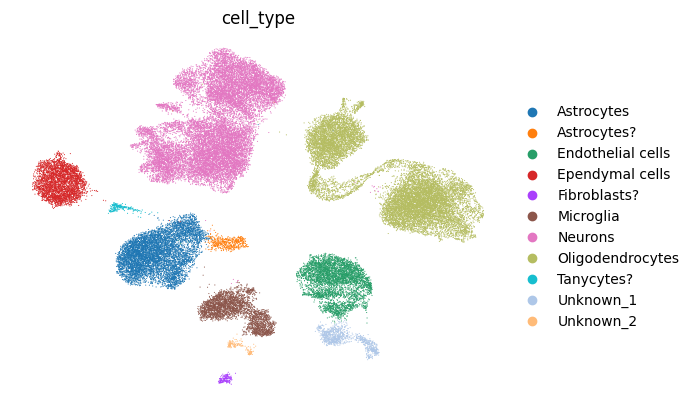

In [146]:
sc.pl.umap(adata, color=['cell_type'], frameon=False)
#, legend_loc='on data'

In [322]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers